In [25]:
import wandb
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
my_secret = user_secrets.get_secret("WANDB_API_KEY") 
wandb.login(key=my_secret)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [1]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.4 MB/s eta 0:00:00


In [2]:
from transformers import AutoTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset, DatasetDict
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import evaluate
import os

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
model = RobertaForSequenceClassification.from_pretrained("vinai/phobert-base-v2", num_labels=2)

In [29]:
data_files = {"train": "train/train.csv", "test": "test/test.csv"}
dataset = load_dataset(path="/kaggle/input/review-dataset", data_files=data_files)

In [30]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 30256
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7576
    })
})

In [31]:
from datasets import DatasetDict

split_train_val = dataset['train'].train_test_split(test_size=0.25)

dataset = DatasetDict({
    'train': split_train_val['train'],
    'validation': split_train_val['test'],
    'test': dataset['test']})

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 22692
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 7564
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7576
    })
})

In [32]:
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=256)

In [33]:
training_set = dataset['train'].map(tokenize_function, batched=True)
validation_set = dataset['validation'].map(tokenize_function, batched=True)
testing_set = dataset['test'].map(tokenize_function, batched=True)

Map:   0%|          | 0/22692 [00:00<?, ? examples/s]

Map:   0%|          | 0/7564 [00:00<?, ? examples/s]

In [34]:
%pip install evaluate
%pip install -U "keras==2.1.6"

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [35]:
import numpy as np
import evaluate

In [36]:
acc_metric = evaluate.load("accuracy")
prec_metric = evaluate.load("precision")
rec_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    acc = acc_metric.compute(predictions=predictions, references=labels)
    prec = prec_metric.compute(predictions=predictions, references=labels)
    rec = rec_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels)
    
    return {
        'accuracy' : acc['accuracy'],
        'precision' : prec["precision"],
        'recall' : rec["recall"],
        'f1' : f1['f1']
    }

In [37]:
%pip install transformers==4.38.2
%pip install torch==2.2.1
%pip install accelerate==0.26.0

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [38]:
run = wandb.init(project='PhoBERT_sentiment_analysis')

In [39]:
batch_size = 16
training_args = TrainingArguments(
    output_dir='/kaggle/temp/phobert-finetuning-sentiment-analysis',
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    seed=19012003
)

In [40]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=training_set,
    eval_dataset=validation_set,
    compute_metrics=compute_metrics
)

In [41]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.219200,0.219311,0.929138,0.912738,0.950888,0.931423
2,0.172700,0.217913,0.930857,0.919523,0.946186,0.932664
3,0.151000,0.272670,0.932047,0.924872,0.942268,0.933489
4,0.121600,0.302486,0.929931,0.915994,0.948537,0.931982
5,0.083000,0.311607,0.929402,0.922958,0.938871,0.930847


TrainOutput(global_step=7095, training_loss=0.15239021269009934, metrics={'train_runtime': 3241.2996, 'train_samples_per_second': 35.004, 'train_steps_per_second': 2.189, 'total_flos': 1.49262901705728e+16, 'train_loss': 0.15239021269009934, 'epoch': 5.0})

In [42]:
trainer.evaluate(testing_set)

{'eval_loss': 0.295724093914032,
 'eval_accuracy': 0.933870116156283,
 'eval_precision': 0.9299560609976738,
 'eval_recall': 0.9399164054336469,
 'eval_f1': 0.9349097050799012,
 'eval_runtime': 55.6194,
 'eval_samples_per_second': 136.211,
 'eval_steps_per_second': 8.522,
 'epoch': 5.0}

In [43]:
pred = trainer.predict(testing_set)

In [44]:
pred

PredictionOutput(predictions=array([[ 3.1726835, -3.0019348],
       [-2.5198748,  2.3996885],
       [-3.272998 ,  3.1465342],
       ...,
       [ 2.4964185, -2.325081 ],
       [ 3.2162566, -3.0315654],
       [ 1.6584713, -1.5765129]], dtype=float32), label_ids=array([0, 1, 1, ..., 1, 0, 0]), metrics={'test_loss': 0.295724093914032, 'test_accuracy': 0.933870116156283, 'test_precision': 0.9299560609976738, 'test_recall': 0.9399164054336469, 'test_f1': 0.9349097050799012, 'test_runtime': 55.5037, 'test_samples_per_second': 136.495, 'test_steps_per_second': 8.54})

In [45]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
huggingface_token = user_secrets.get_secret("HUGGINGFACE_TOKENS")

In [46]:
from huggingface_hub import login
login(token = huggingface_token)

In [47]:
!huggingface-cli whoami

phanlamthanhdu


In [48]:
trainer.push_to_hub()

Upload 6 LFS files:   0%|          | 0/6 [00:00<?, ?it/s]

events.out.tfevents.1742900154.2b9ae7a831ff.32.1:   0%|          | 0.00/560 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/540M [00:00<?, ?B/s]

events.out.tfevents.1742896909.2b9ae7a831ff.32.0:   0%|          | 0.00/10.9k [00:00<?, ?B/s]

events.out.tfevents.1742902109.2b9ae7a831ff.32.2:   0%|          | 0.00/10.9k [00:00<?, ?B/s]

events.out.tfevents.1742905406.2b9ae7a831ff.32.3:   0%|          | 0.00/560 [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.43k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/phanlamthanhdu/phobert-finetuning-sentiment-analysis/commit/2291684f0c3dca5b50259c9ec6d4b2a634fdb16a', commit_message='End of training', commit_description='', oid='2291684f0c3dca5b50259c9ec6d4b2a634fdb16a', pr_url=None, repo_url=RepoUrl('https://huggingface.co/phanlamthanhdu/phobert-finetuning-sentiment-analysis', endpoint='https://huggingface.co', repo_type='model', repo_id='phanlamthanhdu/phobert-finetuning-sentiment-analysis'), pr_revision=None, pr_num=None)

### Testing

In [3]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
model = RobertaForSequenceClassification.from_pretrained("phanlamthanhdu/phobert-sentiment-analysis", num_labels=2)

config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/785 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/540M [00:00<?, ?B/s]

In [4]:
data_files = {"train": "train/train.csv", "test": "test/test.csv"}
dataset = load_dataset(path="/kaggle/input/review-dataset", data_files=data_files)

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 30256
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7576
    })
})

In [6]:
from datasets import DatasetDict

split_train_val = dataset['train'].train_test_split(test_size=0.25)

dataset = DatasetDict({
    'train': split_train_val['train'],
    'validation': split_train_val['test'],
    'test': dataset['test']})

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 22692
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 7564
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7576
    })
})

In [7]:
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=256)

In [8]:
training_set = dataset['train'].map(tokenize_function, batched=True)
validation_set = dataset['validation'].map(tokenize_function, batched=True)
testing_set = dataset['test'].map(tokenize_function, batched=True)

Map:   0%|          | 0/22692 [00:00<?, ? examples/s]

Map:   0%|          | 0/7564 [00:00<?, ? examples/s]

Map:   0%|          | 0/7576 [00:00<?, ? examples/s]

In [9]:
testing_set.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

In [10]:
testing_set

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 7576
})

In [11]:
import torch

In [12]:
from torch.utils.data import DataLoader
from tqdm import tqdm

test_dataloader = DataLoader(testing_set, batch_size=16)

predictions = []
true_labels = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.eval()
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())


100%|██████████| 474/474 [00:52<00:00,  9.03it/s]


In [13]:
from sklearn.metrics import accuracy_score, classification_report

print(classification_report(true_labels, predictions, digits=3))
print("Accuracy:", accuracy_score(true_labels, predictions))
print("Precision:", precision_score(true_labels, predictions))
print("Recall:", recall_score(true_labels, predictions))
print("F1-Score:", f1_score(true_labels, predictions))

              precision    recall  f1-score   support

           0      0.940     0.930     0.935      3748
           1      0.932     0.941     0.937      3828

    accuracy                          0.936      7576
   macro avg      0.936     0.936     0.936      7576
weighted avg      0.936     0.936     0.936      7576

Accuracy: 0.9359820485744457
Precision: 0.9324708926261319
Recall: 0.9414838035527691
F1-Score: 0.9369556739893409


In [14]:
from sklearn.metrics import confusion_matrix

# y_true: true labels
# y_pred: predicted labels
cm = confusion_matrix(true_labels, predictions)
cm

array([[3487,  261],
       [ 224, 3604]])

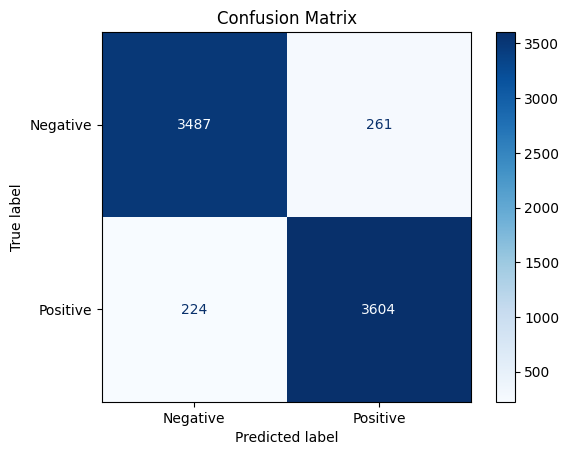

In [15]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [26]:
import pandas as pd

In [27]:
true_labels

[0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,


In [28]:
df = pd.DataFrame({
    'text' : testing_set['text'],
    'true_class' : true_labels,
    'prediction' : predictions
})

In [ ]:
df.text

,text,true_class,prediction
0,"đồ_ăn quá đắt , 3 người ăn hết 6tr3 đồ_ăn tệ n...",0,0
1,"quán ngon , tuy_nhiên khá chật , ít bàn .",1,1
2,"thịt lợn và các món muối siêu ngon ạ , anh ord...",1,1
3,"hải_sản không tươi , nguội và ít món .",0,0
4,cảnh_báo không nên qua quán này ăn gọi đồ 1 đằ...,0,0
...,...,...,...
7571,"khách ngồi ăn chờ lâu , lo bán cho dilivery đe...",0,0
7572,"đồ tươi , ngon , phục_vụ nhanh .",1,1
7573,"đến vì món bún_thang mà không có , hi_vọng quá...",1,0
7574,"tay_nghề đầu_bếp chưa tương_xứng với giá , phụ...",0,0


In [30]:
df.to_csv('/kaggle/working/results.csv', index=False)